In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

%cd gdrive/MyDrive/Отбор на работу/MIL Lab/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Отбор на работу/MIL Lab


# Тестовое задание
Обучить ResNet20 на CIFAR10, реализовать метод квантизации и получить его результаты.


### Рекомендуемые шаги для выполнения задания  
**Шаг 1.** Ознакомиться с понятием Quantization.  

На данном шаге предлагается разобраться с понятием Quantization и со стандартными техниками, как dynamic, static, post training и quantization aware quantization.

**Шаг 2.** Скачать датасет CIFAR10.

Необходимо скачать датасет CIFAR10 для последующих экспериментов.

**Шаг 3.** Реализовать архитектуру ResNet20.

На данном шаге предлагается реализовать известную архитектуру ResNet20 совместно с процедурой ее обучения (с поправкой на датасет CIFAR10).

**Шаг 4.** Обучить ResNet20.  

Нужно обучить реализованную архитектуру на скаченном датасете (точность сети должна быть не менее 90%).  

**Шаг 5.** Применить готовые решения для post training quantization (далее PTQ).  

Воспользоваться [Pytorch Quantization](https://pytorch.org/blog/introduction-to-quantization-on-pytorch/), а именно методом PTQ.
> Квантовать к 16 и 8 битам. Квантовать уже обученную модель, которая была получена на шаге 4.

**Шаг 6.** Реализовать PTQ.  

На данном шаге предлагается реализовать самостоятельно метод PTQ. Данный метод в основном состоит из следующих 2-х шагов:  
1. Собрать статистики тензоров весов (можно за одну итерацию) и статистики тензора активаций (необходимо несколько итераций).  
2. Инициализируя scale_factor и offset согласно собранным статистикам квантовать сеть и получить результаты на тестовом датасете.  

> Квантовать к 16, 8, 4 и 2 битам. Квантовать уже обученную модель, которая была получена на шаге 4.

**Шаг 7.** Сравнение результатов.  

Сравните результаты, полученные с помощью готового решения и реализованного Вами на шаге 6. Обратите внимание на результаты при квантовании сети реализованным методом к 4 и 2 битам. Сформулируйте выводы из проведенного анализа результатов. Предложите свои идеи, как можно улучшить текущие результаты.


### Что будет оцениваться?
1. Оформление кода на github.
2. Оформление результатов.
3. Структура репозитория.
4. Соответствие решения тестовому заданию.
5. Любые релевантные теме мысли, идеи и соображения.


In [ ]:
import torch
import torch.nn as nn

from torchsummary import summary

import numpy as np
import random
import os

from model import *
from data import *
from train import *

from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
RANDOM_SEED = 1712
    
init_random_seed(value=RANDOM_SEED)

**Шаг 2.** Скачать датасет CIFAR10.

Необходимо скачать датасет CIFAR10 для последующих экспериментов.

In [ ]:
loader_train, loader_test = get_data()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
loader_train.dataset.data.shape

(50000, 32, 32, 3)

In [ ]:
loader_test.dataset.data.shape

(10000, 32, 32, 3)

**Шаг 3.** Реализовать архитектуру ResNet20.

На данном шаге предлагается реализовать известную архитектуру ResNet20 совместно с процедурой ее обучения (с поправкой на датасет CIFAR10).

In [ ]:
resnet20 = ResNet(BasicBlock, [3, 3, 3])

In [ ]:
summary(resnet20.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

**Шаг 4.** Обучить ResNet20.  

Нужно обучить реализованную архитектуру на скаченном датасете (точность сети должна быть не менее 90%).  

In [ ]:
# Hyper-parameters
num_epochs = 200
learning_rate = 1e-2

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet20.parameters(), lr=learning_rate,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train_loss: 0.015
  val_loss: 0.361
Accuracy of the resnet20 on the train images: 99.7
Accuracy of the resnet20 on the val images: 90.9


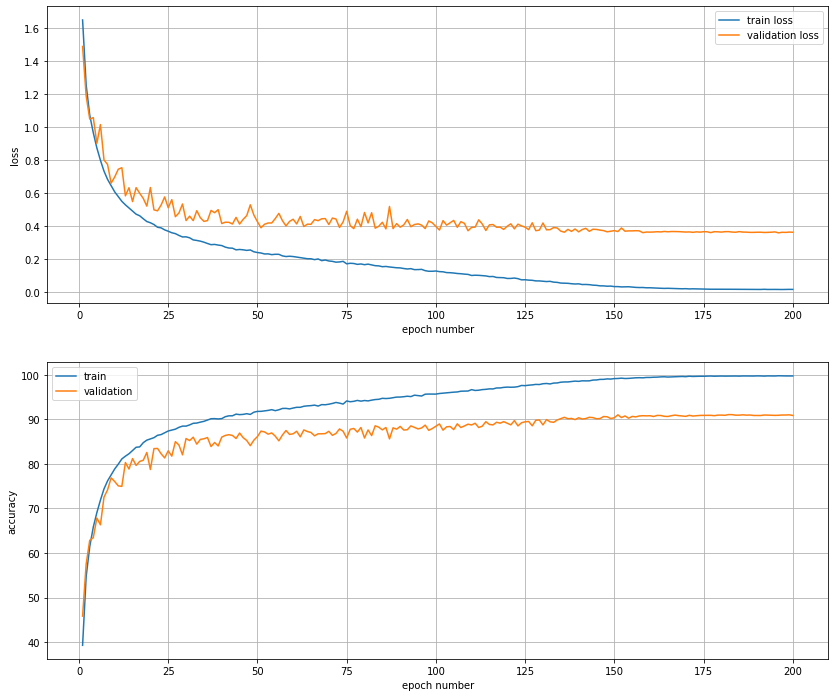

In [ ]:
train_model(resnet20, num_epochs, criterion, optimizer, scheduler, loader_train, loader_test, device, with_plt=True)

Check trained model

In [ ]:
resnet20.load_state_dict(torch.load('lr_0.01_SGD_NEW__epoch_150_91.02_resnet20.ckpt'))

<All keys matched successfully>

In [ ]:
testing(resnet20, loader_train, name='Train')
testing(resnet20, loader_test, name='Test')

Accuracy of the model on the Train images: 99.544 %
Accuracy of the model on the Test images: 91.02 %



**Шаг 5.** Применить готовые решения для post training quantization (далее PTQ). 

Воспользоваться [Pytorch Quantization](https://pytorch.org/blog/introduction-to-quantization-on-pytorch/), а именно методом PTQ.
> Квантовать к 16 и 8 битам. Квантовать уже обученную модель, которая была получена на шаге 4.

In [ ]:
resnet20_PTQ = PTQResNet(PTQBasicBlock, [3, 3, 3]).to('cpu')
resnet20_PTQ.load_state_dict(torch.load('lr_0.01_SGD_NEW__epoch_150_91.02_resnet20.ckpt'))
resnet20_PTQ.eval()
print(1)

1


In [ ]:
# Fuse the model in place rather manually.
resnet20_PTQ = torch.quantization.fuse_modules(resnet20_PTQ, [["conv1", "bn1"]], inplace=True)
for module_name, module in resnet20_PTQ.named_children():
    if "layer" in module_name:
        for basic_block_name, basic_block in module.named_children():
            torch.quantization.fuse_modules(basic_block, [["conv1", "bn1"], ["conv2", "bn2"]], inplace=True)
            for sub_block_name, sub_block in basic_block.named_children():
                if sub_block_name == "shortcut":
                    torch.quantization.fuse_modules(sub_block, [["0", "1"]], inplace=True)


In [ ]:
resnet20_PTQ.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(resnet20_PTQ, inplace=True)
resnet20_PTQ.eval()

for i, (images, labels) in tqdm(enumerate(loader_train)):
    images = images.to('cpu')
    resnet20_PTQ(images)
torch.quantization.convert(resnet20_PTQ, inplace=True)
print(2)

/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:124: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
391it [02:12,  2.96it/s]
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


2


In [ ]:
def print_size_of_model(model, name='model'):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print(f'Size of {name} (MB): {size/1e6} ')
    os.remove('temp.p')

In [ ]:
%%time
print_size_of_model(resnet20,'original resnet20')
testing(resnet20.to('cpu'), loader_test, name='Test',device='cpu')

Size of original resnet20 (MB): 1.135489 
Accuracy of the model on the Test images: 91.02 %
CPU times: user 15.2 s, sys: 1.1 s, total: 16.3 s
Wall time: 16.2 s


In [ ]:
%%time
print_size_of_model(resnet20_PTQ,'original resnet20_PTQ')
testing(resnet20_PTQ, loader_test, name='Test',device='cpu')

Size of original resnet20_PTQ (MB): 0.332241 
Accuracy of the model on the Test images: 90.59 %
CPU times: user 16.2 s, sys: 664 ms, total: 16.8 s
Wall time: 16.8 s


**Шаг 6.** Реализовать PTQ.  

На данном шаге предлагается реализовать самостоятельно метод PTQ. Данный метод в основном состоит из следующих 2-х шагов:  
1. Собрать статистики тензоров весов (можно за одну итерацию) и статистики тензора активаций (необходимо несколько итераций).  
2. Инициализируя scale_factor и offset согласно собранным статистикам квантовать сеть и получить результаты на тестовом датасете.  

> Квантовать к 16, 8, 4 и 2 битам. Квантовать уже обученную модель, которая была получена на шаге 4.


данный шаг будет сделан в ближайшее время по следующему [туториалу](https://karanbirchahal.medium.com/how-to-quantise-an-mnist-network-to-8-bits-in-pytorch-no-retraining-required-from-scratch-39f634ac8459)

**Шаг 7.** Сравнение результатов.  

Сравните результаты, полученные с помощью готового решения и реализованного Вами на шаге 6. Обратите внимание на результаты при квантовании сети реализованным методом к 4 и 2 битам. Сформулируйте выводы из проведенного анализа результатов. Предложите свои идеи, как можно улучшить текущие результаты.